# Metadata

* Title: **Final Project Report**
* Class: DS 5100
* Date: 17 July 2022
* Student Name: Griffin McCauley
* Student Net ID: kzj5qw
* This URL: https://github.com/Griffin-McCauley/DS5100-Final-Project/blob/main/final-project-submission.ipynb
* GitHub Repo URL: https://github.com/Griffin-McCauley/DS5100-Final-Project

# The Monte Carlo Module

In [1]:
import numpy as np
import pandas as pd

class Die():
    '''This Die class defines an object which has N sides, or “faces”, and W weights, and can be rolled to select a face.'''
    
    def __init__(self, faces):
        '''
        This initializer takes an array of faces (strings or numbers) as an input and defines a uniform distribution over the sample space of faces, storing this distribution as a private dataframe.
        '''
        if len(set(map(type, faces))) == 1:
            self.faces = np.array(faces)
            self.weights = np.ones(len(faces))
            self._die = pd.DataFrame({'faces':self.faces, 'weights':self.weights})
        else:
            return print('Please input face values of the same data type.')
        
    def change_weight(self, face, new_weight):
        '''
        Purpose: to change the weight of a single side
        Inputs: 
            - the face value to be changed (string or number depending on initialization)
            - the new weight (float)
        Output: a modified weights distribution
        '''
        if face not in self.faces:
            return print('Please input a valid face value.')
        try:
            new_weight = float(new_weight)
        except ValueError:
            return print('Please input a valid weight value (i.e. a float).')       
        self.weights[self.faces == face] = new_weight
        self._die['weights'] = self.weights
                
    def roll(self, n = 1):
        '''
        Purpose: to roll the die one or more times
        Input: a number to specify how many times the dice should be rolled
        Output: a list of outcomes
        '''
        try:
            n = round(float(n))
        except ValueError:
            return print('Please input a valid number of rolls (i.e. an integer).')
        probs = [i/sum(self.weights) for i in self.weights]
        return [self._die.faces.sample(weights=probs).values[0] for roll in range(n)]
            
    def show_die(self):
        '''This method shows the die’s current set of faces and weights.'''
        return self._die
    
        
class Game():
    '''This Game class defines an object which consists of rolling of one or more dice of the same kind one or more times. '''
    
    def __init__(self, dice):
        '''This initializer takes a list of already instantiated similar Die objects as its single input parameter.'''
        self.dice = dice
        
    def play(self, n):
        '''
        Purpose: to play the game by rolling the dice a specified number of times
        Input: a number to specify how many times the dice should be rolled
        Output: a private dataframe of shape N rolls by M dice with each entry indicating the face rolled in that instance
        '''
        try:
            n = round(float(n))
        except ValueError:
            return print('Please input a valid number of rolls (i.e. an integer).')
        results = pd.DataFrame()
        for i in range(len(self.dice)):
            results = pd.concat([results, pd.DataFrame({i:self.dice[i].roll(n)})], axis=1)
        results.index = [i+1 for i in range(n)]
        results.index.name = 'roll_number'
        results.columns.name = 'die_number'
        self._results = results

    def show_result(self, form = 'wide'):
        '''
        Purpose: to pass the private dataframe of results to the user
        Input: a form parameter ('wide' or 'narrow'), specifying whether to return the dataframe in 'narrow' or 'wide' form
        Output: the private dataframe of results
        '''
        if form == 'wide':
            return self._results
        elif form == 'narrow':
            return self._results.stack().to_frame('face_rolled')
        elif form not in ['wide','narrow']:
            raise Exception("The form parameter must be 'wide' or 'narrow'.")
    
        
class Analyzer():
    '''This Analyzer class defines an object which takes the results of a single game and computes various descriptive statistical properties about it.'''

    def __init__(self, game):
        '''This initializer takes a game object as its single input parameter.'''
        self.game = game
        
    def jackpot(self):
        '''This method computes how many times the game resulted in all faces being identical.'''
        jackpot_df = pd.DataFrame()
        for i in range(len(self.game._results)):
            jackpot_df = pd.concat([jackpot_df, pd.DataFrame({'jackpot': [(len(set(self.game._results.iloc[i])) == 1)]})], axis = 0)
        jackpot_df.index = [i+1 for i in range(len(self.game._results))]
        jackpot_df.index.name = 'roll_number'
        self.jackpots = jackpot_df
        return int(sum(self.jackpots['jackpot']))
    
    def combo(self):
        '''This method computes the distinct combinations of faces rolled, along with their counts.'''
        rolls = [sorted(list(self.game._results.iloc[i])) for i in range(len(self.game._results))]
        self.combos = pd.DataFrame(rolls).value_counts().to_frame('counts')
        
    def face_counts_per_roll(self):
        '''This method computes how many times a given face is rolled in each event.'''
        fcpr = pd.DataFrame()
        for i in range(len(self.game._results)):
            fcpr = pd.concat([fcpr, pd.DataFrame({'Ace': [sum(list(self.game._results.iloc[i] == 'Ace'))], 'King': [sum(list(self.game._results.iloc[i] == 'King'))], 'Queen': [sum(list(self.game._results.iloc[i] == 'Queen'))], 'Jack': [sum(list(self.game._results.iloc[i] == 'Jack'))]})], axis = 0)
        fcpr.index = [i+1 for i in range(len(self.game._results))]
        fcpr.index.name = 'roll_number'
        self.face_counts_per_roll = fcpr

# Test Module

In [2]:
import numpy as np
import pandas as pd
import unittest
from montecarlo.montecarlo import Die, Game, Analyzer

class DieGameTestSuite(unittest.TestCase):
    '''This DieGameTestSuite class contains the test suite of methods used to unit test the Die, Game, and Analyzer classes.'''
    
    def test_001_init(self):
        '''This test checks that the __init__ method of the Die class correctly initializes a die object.'''
        die = Die(['H', 'T'])
        self.assertTrue(all(np.array(die._die['faces']) == np.array(['H','T'])) and all(np.array(die._die['weights']) == np.ones(len(['H','T']))))
        
    def test_002_change_weight_success(self):
        '''This test checks that the change_weight method of the Die class correctly changes the weight of a single side.'''
        die = Die(['Ace', 'King', 'Queen', 'Jack'])
        die.change_weight('Ace', 10)
        self.assertTrue(die.weights[die.faces == 'Ace'] == 10 and all(weight == 1 for weight in die.weights[die.faces != 'Ace']))
        
    def test_003_change_weight_failure(self):
        '''This test checks that the change_weight method of the Die class does not change the weight of a single side when given an incorrect input.'''
        die = Die(['Ace', 'King', 'Queen', 'Jack'])
        die.change_weight('Ace', 'ten')
        self.assertTrue(die.weights[die.faces == 'Ace'] == 1)
        
    def test_004_roll_success(self):
        '''This test checks that the roll method of the Die class correctly outputs a list of outcomes.'''
        die = Die(['H', 'T'])
        outcomes = die.roll(10)
        self.assertTrue(len(outcomes) == 10 and all(outcome in ['H', 'T'] for outcome in outcomes))
        
    def test_005_roll_failure(self):
        '''This test checks that the roll method of the Die class does not output a list of outcomes when given an incorrect input.'''
        die = Die(['H', 'T'])
        outcomes = die.roll('ten')
        self.assertTrue(outcomes == None)
        
    def test_006_show_die(self):
        '''This test checks that the show_die method of the Die class correctly returns the private dataframe of the .die attribute.'''
        die = Die(['H', 'T'])
        shown = die.show_die()
        self.assertTrue(all(np.array(shown['faces']) == np.array(['H','T'])) and all(np.array(shown['weights']) == np.ones(len(['H','T']))))
        
         
    def test_010_init(self):
        '''This test checks that the __init__ method of the Game class correctly initializes a game object.'''
        die1 = Die(['Ace', 'King', 'Queen', 'Jack'])
        die2 = Die(['Ace', 'King', 'Queen', 'Jack'])
        die3 = Die(['Ace', 'King', 'Queen', 'Jack'])
        game = Game([die1, die2, die3])
        self.assertTrue(all(type(die) == Die for die in game.dice))
        
    def test_020_play_success(self):
        '''This test checks that the play method of the Game class correctly generates the ._results attribute of the game object.'''
        die1 = Die(['Ace', 'King', 'Queen', 'Jack'])
        die2 = Die(['Ace', 'King', 'Queen', 'Jack'])
        die3 = Die(['Ace', 'King', 'Queen', 'Jack'])
        game = Game([die1, die2, die3])
        game.play(10)
        self.assertTrue(game._results.shape == (10, 3) and game._results.index.names[0] == 'roll_number' and game._results.columns.names[0] == 'die_number')
                
    def test_030_play_failure(self):
        '''This test checks that play method of the Game class does not generate the ._results attribute of the game object.'''
        die1 = Die(['Ace', 'King', 'Queen', 'Jack'])
        die2 = Die(['Ace', 'King', 'Queen', 'Jack'])
        die3 = Die(['Ace', 'King', 'Queen', 'Jack'])
        game = Game([die1, die2, die3])
        game.play('ten')
        self.assertFalse(hasattr(game, '_results'))
        
    def test_040_show_result_narrow(self):
        '''This test checks that the show_result method of the Game class correctly outputs the results dataframe in narrow format when provided the 'narrow' argument.'''
        die1 = Die(['Ace', 'King', 'Queen', 'Jack'])
        die2 = Die(['Ace', 'King', 'Queen', 'Jack'])
        die3 = Die(['Ace', 'King', 'Queen', 'Jack'])
        game = Game([die1, die2, die3])
        game.play(10)
        result = game.show_result('narrow')
        self.assertTrue(result.shape == (30, 1) and result.index.names == ['roll_number', 'die_number'] and result.columns[0] == 'face_rolled')
        
    def test_050_show_result_failure(self):
        '''This test checks that the show_result method of the Game class raises an exception if the user passes an invalid option (i.e. not 'wide' or 'narrow').'''
        die1 = Die(['Ace', 'King', 'Queen', 'Jack'])
        die2 = Die(['Ace', 'King', 'Queen', 'Jack'])
        die3 = Die(['Ace', 'King', 'Queen', 'Jack'])
        game = Game([die1, die2, die3])
        game.play(10)
        with self.assertRaises(Exception):
            game.show_result('standard')
            
                       
    def test_100_init(self):
        '''This test checks that the __init__ method of the Analyzer class correctly initializes an analyzer object.'''
        die1 = Die(['Ace', 'King', 'Queen', 'Jack'])
        die2 = Die(['Ace', 'King', 'Queen', 'Jack'])
        die3 = Die(['Ace', 'King', 'Queen', 'Jack'])
        game = Game([die1, die2, die3])
        game.play(10)
        analyzer = Analyzer(game)
        self.assertTrue(analyzer.game._results.shape == (10, 3))
        
    def test_200_jackpot(self):
        '''This test checks that jackpot method of the Analyzer class outputs a value of the correct type and that it correctly generates the .jackpots attribute of the analyzer object.'''
        die1 = Die(['Ace', 'King', 'Queen', 'Jack'])
        die2 = Die(['Ace', 'King', 'Queen', 'Jack'])
        die3 = Die(['Ace', 'King', 'Queen', 'Jack'])
        game = Game([die1, die2, die3])
        game.play(10)
        analyzer = Analyzer(game)
        jackpots = analyzer.jackpot()
        self.assertTrue(type(jackpots) == int and len(analyzer.jackpots) == 10)
        
    def test_300_combo(self):
        '''This test checks that the combo method of the Analyzer class correctly generates the .combos attribute of the analyzer object.'''
        die1 = Die(['Ace', 'King', 'Queen', 'Jack'])
        die2 = Die(['Ace', 'King', 'Queen', 'Jack'])
        die3 = Die(['Ace', 'King', 'Queen', 'Jack'])
        game = Game([die1, die2, die3])
        game.play(10)
        analyzer = Analyzer(game)
        analyzer.combo()
        self.assertTrue(hasattr(analyzer, 'combos') and analyzer.combos.columns[0] == 'counts' and sum(analyzer.combos['counts']) == 10)
        
    def test_400_face_counts_per_roll(self):
        '''This test checks that the face_counts_per_roll method of the Analyzer class correctly generates the .face_counts_per_roll attribute of the analyzer object.'''
        die1 = Die(['Ace', 'King', 'Queen', 'Jack'])
        die2 = Die(['Ace', 'King', 'Queen', 'Jack'])
        die3 = Die(['Ace', 'King', 'Queen', 'Jack'])
        game = Game([die1, die2, die3])
        game.play(10)
        analyzer = Analyzer(game)
        analyzer.face_counts_per_roll()
        self.assertTrue(hasattr(analyzer, 'face_counts_per_roll') and analyzer.face_counts_per_roll.shape == (10, 4) and all([sum(analyzer.face_counts_per_roll.iloc[i]) == 3 for i in range(len(analyzer.face_counts_per_roll))]))
           
                        
if __name__ == '__main__':
    unittest.main(verbosity=2,
                  # the following line allows this cell to exist in a .pynb file
                 argv=['first-arg-is-ignored'], exit=False)

test_001_init (__main__.DieGameTestSuite)
This test checks that the __init__ method of the Die class correctly initializes a die object. ... ok
test_002_change_weight_success (__main__.DieGameTestSuite)
This test checks that the change_weight method of the Die class correctly changes the weight of a single side. ... ok
test_003_change_weight_failure (__main__.DieGameTestSuite)
This test checks that the change_weight method of the Die class does not change the weight of a single side when given an incorrect input. ... ok
test_004_roll_success (__main__.DieGameTestSuite)
This test checks that the roll method of the Die class correctly outputs a list of outcomes. ... ok
test_005_roll_failure (__main__.DieGameTestSuite)
This test checks that the roll method of the Die class does not output a list of outcomes when given an incorrect input. ... ok
test_006_show_die (__main__.DieGameTestSuite)
This test checks that the show_die method of the Die class correctly returns the private dataframe o

Welcome to my Monte Carlo module.
Please input a valid weight value (i.e. a float).
Please input a valid number of rolls (i.e. an integer).
Please input a valid number of rolls (i.e. an integer).


ok
test_200_jackpot (__main__.DieGameTestSuite)
This test checks that jackpot method of the Analyzer class outputs a value of the correct type and that it correctly generates the .jackpots attribute of the analyzer object. ... ok
test_300_combo (__main__.DieGameTestSuite)
This test checks that the combo method of the Analyzer class correctly generates the .combos attribute of the analyzer object. ... ok
test_400_face_counts_per_roll (__main__.DieGameTestSuite)
This test checks that the face_counts_per_roll method of the Analyzer class correctly generates the .face_counts_per_roll attribute of the analyzer object. ... ok

----------------------------------------------------------------------
Ran 15 tests in 0.434s

OK


# Test Results

test_001_init (__main__.DieGameTestSuite)

This test checks that the __init__ method of the Die class correctly initializes a die object. ... ok

test_002_change_weight_success (__main__.DieGameTestSuite)

This test checks that the change_weight method of the Die class correctly changes the weight of a single side. ... ok

test_003_change_weight_failure (__main__.DieGameTestSuite)

This test checks that the change_weight method of the Die class does not change the weight of a single side when given an incorrect input. ... ok

test_004_roll_success (__main__.DieGameTestSuite)

This test checks that the roll method of the Die class correctly outputs a list of outcomes. ... ok

test_005_roll_failure (__main__.DieGameTestSuite)

This test checks that the roll method of the Die class does not output a list of outcomes when given an incorrect input. ... ok

test_006_show_die (__main__.DieGameTestSuite)

This test checks that the show_die method of the Die class correctly returns the private dataframe of the .die attribute. ... ok

test_010_init (__main__.DieGameTestSuite)

This test checks that the __init__ method of the Game class correctly initializes a game object. ... ok

test_020_play_success (__main__.DieGameTestSuite)

This test checks that the play method of the Game class correctly generates the ._results attribute of the game object. ... ok

test_030_play_failure (__main__.DieGameTestSuite)

This test checks that play method of the Game class does not generate the ._results attribute of the game object. ... ok

test_040_show_result_narrow (__main__.DieGameTestSuite)

This test checks that the show_result method of the Game class correctly outputs the results dataframe in narrow format when provided the 'narrow' argument. ... ok

test_050_show_result_failure (__main__.DieGameTestSuite)

This test checks that the show_result method of the Game class raises an exception if the user passes an invalid option (i.e. not 'wide' or 'narrow'). ... ok

test_100_init (__main__.DieGameTestSuite)

This test checks that the __init__ method of the Analyzer class correctly initializes an analyzer object. ... ok

test_200_jackpot (__main__.DieGameTestSuite)

This test checks that jackpot method of the Analyzer class outputs a value of the correct type and that it correctly generates the .jackpots attribute of the analyzer object. ... ok

test_300_combo (__main__.DieGameTestSuite)

This test checks that the combo method of the Analyzer class correctly generates the .combos attribute of the analyzer object. ... ok

test_400_face_counts_per_roll (__main__.DieGameTestSuite)

This test checks that the face_counts_per_roll method of the Analyzer class correctly generates the .face_counts_per_roll attribute of the analyzer object. ... ok

----------------------------------------------------------------------
Ran 15 tests in 0.178s

OK

# Scenarios

Code blocks with your scenarios and their outputs. 

These should have appropriate import statements even though the code is now in the same notebook as the classes it calls. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from montecarlo.montecarlo import Die, Game, Analyzer

## Scenario 1: A 2-headed coin

#### 1. Create a fair coin (with faces H and T) and one unfair coin, in which one of the faces has a weight of 5 and the others 1.

In [4]:
fair_coin = Die(['H', 'T'])
unfair_coin = Die(['H', 'T'])
unfair_coin.change_weight('H', 5)

#### 2. Play a game of 1000 flips of three coins with all fair dice.

In [5]:
num_rolls = 1000
fair_game = Game([fair_coin, fair_coin, fair_coin])
fair_game.play(num_rolls)

#### 3. Play a game of 1000 flips with two unfair dice and one fair die.

In [6]:
unfair_game = Game([fair_coin, unfair_coin, unfair_coin])
unfair_game.play(num_rolls)

#### 4. For each game, use an Analyzer object to determine the relative frequency of jackpots – getting either all Hs or all Ts.
##### (5. Compute relative frequency as the number of jackpots over the total number of rolls.)

In [7]:
fair_analyzer = Analyzer(fair_game)
relative_fair_frequency = fair_analyzer.jackpot()/num_rolls
print('Relative fair frequency:', relative_fair_frequency)

Relative fair frequency: 0.249


In [8]:
expected_fair_frequency = 2*(1/2)**3
print('Expected fair frequency:', expected_fair_frequency)

Expected fair frequency: 0.25


In [9]:
unfair_analyzer = Analyzer(unfair_game)
relative_unfair_frequency = unfair_analyzer.jackpot()/num_rolls
print('Relative unfair frequency:', relative_unfair_frequency)

Relative unfair frequency: 0.354


In [10]:
expected_unfair_frequency = (1/2)*(5/6)*(5/6) + (1/2)*(1/6)*(1/6)
print('Expected unfair frequency:', expected_unfair_frequency)

Expected unfair frequency: 0.36111111111111116


#### 6. Show your results, comparing the two relative frequencies, in a simple bar chart.

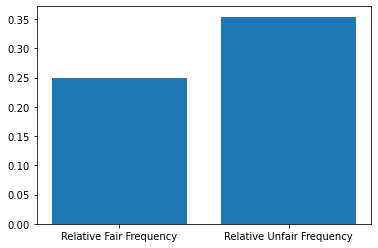

In [11]:
fig = plt.figure()

plt.bar(['Relative Fair Frequency', 'Relative Unfair Frequency'], 
        [relative_fair_frequency, relative_unfair_frequency]);

## Scenario 2: A 6-sided die

#### 1. Create a fair die and two unfair dice, all of six sides with the faces 1 through 6. One unfair die (Type 1) will weight 6 five times more than the others (i.e. it has weight of 5 and the others a weight of 1 each). The other unfair die (Type 2) will  weight 1 five times more than the others.

In [12]:
fair_die = Die([1, 2, 3, 4, 5, 6])
unfair_die_type1 = Die([1, 2, 3, 4, 5, 6])
unfair_die_type1.change_weight(6, 5)
unfair_die_type2 = Die([1, 2, 3, 4, 5, 6])
unfair_die_type2.change_weight(1, 5)

#### 2. Play a game of 10000 rolls with 5 fair dice.

In [13]:
num_rolls = 10000
fair_game = Game([fair_die, fair_die, fair_die, fair_die, fair_die])
fair_game.play(num_rolls)

#### 3. Play a game of 10000 rolls with 2 unfair dice of type 1, 1 unfair die of type 2, and the rest fair dice.

In [14]:
unfair_game = Game([unfair_die_type1, unfair_die_type1, unfair_die_type2, fair_die, fair_die])
unfair_game.play(num_rolls)

#### 4. For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.

In [15]:
fair_analyzer = Analyzer(fair_game)
fair_jackpots = fair_analyzer.jackpot()
relative_fair_frequency = fair_jackpots/num_rolls
print('Relative fair frequency:', relative_fair_frequency)
expected_fair_frequency = (1/6)**4
print('Expected fair frequency:', expected_fair_frequency)

Relative fair frequency: 0.0002
Expected fair frequency: 0.0007716049382716048


In [16]:
unfair_analyzer = Analyzer(unfair_game)
unfair_jackpots = unfair_analyzer.jackpot()
relative_unfair_frequency = unfair_jackpots/num_rolls
print('Relative unfair frequency:', relative_unfair_frequency)
expected_unfair_frequency = ((1/10)*(1/10)*(1/2)*(1/6)*(1/6)) + ((1/10)*(1/10)*(1/10)*(1/6)*(1/6)) + \
((1/10)*(1/10)*(1/10)*(1/6)*(1/6)) + ((1/10)*(1/10)*(1/10)*(1/6)*(1/6)) + ((1/10)*(1/10)*(1/10)*(1/6)*(1/6)) + \
((1/2)*(1/2)*(1/10)*(1/6)*(1/6))
print('Expected unfair frequency:', expected_unfair_frequency)

Relative unfair frequency: 0.0015
Expected unfair frequency: 0.0009444444444444444


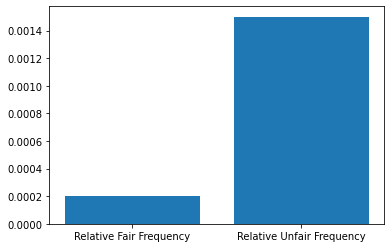

In [17]:
fig = plt.figure()

plt.bar(['Relative Fair Frequency', 'Relative Unfair Frequency'], 
        [relative_fair_frequency, relative_unfair_frequency]);

#### 5. Also compute 10 most frequent combinations of faces for each game. Plot each of these as bar charts.

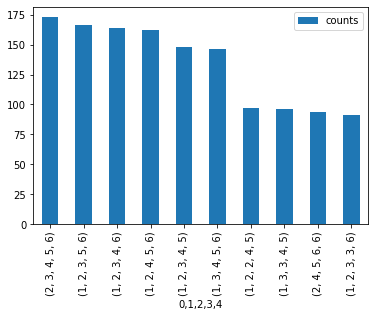

In [18]:
fair_analyzer.combo()
fair_analyzer.combos[:10].plot.bar();

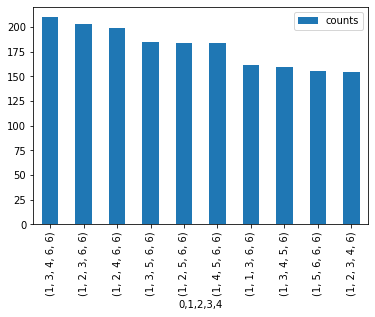

In [19]:
unfair_analyzer.combo()
unfair_analyzer.combos[:10].plot.bar();

## Scenario 3: Letters of the Roman Alphabet

#### 1. Create a "die" of letters from a to z with weights based on their frequency of usage. See Appendix for these weights.

In [20]:
letter_freqs = pd.read_csv('letter-freqs.csv', sep = '\t', header = None)
letters = [letter_freqs.iloc[i][0] for i in range(len(letter_freqs))]
die = Die(letters)
for i in range(len(letter_freqs)):
    die.change_weight(letter_freqs.iloc[i][0], letter_freqs.iloc[i][1])

#### 2. Play a game involving 5 of these dice with 1000 rolls.

In [21]:
num_rolls = 1000
game = Game([die, die, die, die, die])
game.play(num_rolls)

#### 3. How many combos can you that look like actual English words?

In [22]:
words = game.show_result().iloc[:,0] + game.show_result().iloc[:,1] + game.show_result().iloc[:,2] + \
game.show_result().iloc[:,3] + game.show_result().iloc[:,4]
words = words.str.lower()

In [23]:
five_letter_words = pd.read_csv('sgb-words.txt', header = None)
actual_word_count = five_letter_words.isin(words.values).sum()[0]
print('Actual Word Count:', actual_word_count)

Actual Word Count: 5


#### 4. Based on your eye count, what is the relative frequency of these words versus the rest?

In [24]:
relative_word_frequency = actual_word_count/num_rolls
print('Relative Actual Word Count:', relative_word_frequency)

Relative Actual Word Count: 0.005


# Directory Listing

A code block that executes the following bash command: 

```bash
!ls -lRF -o
```

In [25]:
!ls -lRF -o

total 296
-rw-r--r--  1 griffinmccauley   1073 Jul 12 09:03 LICENSE
-rw-r--r--  1 griffinmccauley    168 Jul 12 12:06 README.md
-rw-r--r--  1 griffinmccauley  46184 Jul 13 16:23 final-project-submission.ipynb
-rw-r--r--@ 1 griffinmccauley    234 Jul 12 11:39 letter-freqs.csv
drwxr-xr-x  7 griffinmccauley    224 Jul 13 16:22 montecarlo/
-rw-r--r--  1 griffinmccauley  48068 Jul 13 16:05 montecarlo_demo.ipynb
-rw-r--r--  1 griffinmccauley    384 Jul 13 10:12 setup.py
-rw-r--r--@ 1 griffinmccauley  34542 Jul 12 18:43 sgb-words.txt

./montecarlo:
total 24
-rw-r--r--  1 griffinmccauley    42 Jul 12 09:15 __init__.py
drwxr-xr-x  4 griffinmccauley   128 Jul 13 16:22 __pycache__/
-rw-r--r--  1 griffinmccauley  5687 Jul 13 15:37 montecarlo.py
drwxr-xr-x  5 griffinmccauley   160 Jul 13 16:22 tests/

./montecarlo/__pycache__:
total 24
-rw-r--r--  1 griffinmccauley   226 Jul 13 16:22 __init__.cpython-39.pyc
-rw-r--r--  1 griffinmccauley  6876 Jul 13 16:22 montecarlo.cpython-39.pyc

./montecarlo/tes

# Installation Output Listing
    
A code block that executes the code to install your your package and outputs a successful installation.

In [26]:
!pip install e .

Processing /Users/griffinmccauley/Documents/MSDS/DS5100/DS5100-Final-Project
  Preparing metadata (setup.py) ... done
  Created wheel for Monte-Carlo-Simulator: filename=Monte_Carlo_Simulator-1.0.0-py3-none-any.whl size=4155 sha256=dac745ace7f5be66721457c624ff32ddfd84e79b6374e8e75ff756580fba3142
  Stored in directory: /Users/griffinmccauley/Library/Caches/pip/wheels/64/2f/70/4c963c8e7da99aec15867c28d0be28866251154567ff50b2ea
Successfully built Monte-Carlo-Simulator
  Attempting uninstall: Monte-Carlo-Simulator
    Found existing installation: Monte-Carlo-Simulator 1.0.0
    Uninstalling Monte-Carlo-Simulator-1.0.0:
      Successfully uninstalled Monte-Carlo-Simulator-1.0.0
